In [3]:
# This is an implementation of imp step based on Gorte paper 

In [1]:
# load dependencies'
import concurrent.futures
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import osmnx as ox
import networkx as nx
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
from urllib.parse import urljoin
from shapely.geometry import Point, LineString, Polygon
import pyproj 
from algorithms import mm_utils
from Fuzzy.FIS1 import FIS1
# read data 
gdf = pd.read_pickle('envirocar.pkl')

print(gdf.crs)
# get road network 
# Get the bounding box
bbox = gdf.total_bounds

# 'total_bounds' returns a tuple with (minx, miny, maxx, maxy) values
minx, miny, maxx, maxy = bbox

# Download a map by specifying the bounding box
# and draw the graph
G = ox.graph.graph_from_bbox(maxy, miny, maxx, minx, network_type='drive') 

# extract road info 
nodes, edges = ox.graph_to_gdfs(G)

# project edges into UTM 31 projection 
edges_utm = edges.to_crs({'init': 'epsg:32631'})

# append latitude and longitude to utm edges 
edges_utm['lat_lon'] = edges['geometry']

# convert osmid into unique string id 
edges_utm['str_id'] = edges_utm['osmid'].apply(conc)

None


In [2]:
def get_bearing(point1, point2):
    # this code calculate the bearing of any given pair of longitude, latitude  
    geodesic = pyproj.Geod(ellps='WGS84')
    fwd_azimuth,back_azimuth,distance = geodesic.inv(point1[0], point1[1], point2[0], point2[1])
    return fwd_azimuth

def edge_bearing(edge):
    # this function calculate the bearing from the starting and ending node of each road segment
    bearing = get_bearing(edge[0], edge[len(edge) - 1])
    return(bearing)
    
def conv_angle(angle):
    # this function convert angle from -pi,pi to 0,2*pi
    if angle < 0 :
        angle = angle + 360
    return(angle)

def conc(a):
    #function to convert list or integer in osmid into a unique string id 
    if type(a) is int:
        return str(a)
    ans = ",".join(map(str, a))
    return ans


In [19]:
# initialization for IMP
count = 0 
same_link = 0
stop_iter = False
iter = 0

# saving answer for debugging purposes 
# edge_link saves all the candidate link name for each iteration 
edge_link = []
# fis_res saves the output of FIS algorithm at every iteration 
fis_res = []
# HE_iter saves the heading error values for each candidate edge at any given iteration 
HE_iter = [] 


# save candidate link name each iteration  
candidate_link_res = []

while stop_iter == False :
#for i in range(13, 17):
    #print(iter)
    # get position 
    lon = gdf['geometry'].x[iter]
    lat = gdf['geometry'].y[iter]
    curr_point = np.array([lon, lat])

    #----------------------------------------
    # create error region as SpatialPolygon 
    #----------------------------------------
    # error size 
    err_size = 38
    # initialzie points 
    # use utm for crs : 
    UTMzone = (180 + 5) // 6 + 1
    #crs_str = f"+proj=utm +zone={UTMzone} +ellps=WGS84 +datum=WGS84"
    crs_str ="epsg:4326"

    # initialize projection to standard WGS 84 
    locs = gpd.GeoDataFrame(geometry = gdf['geometry'], crs = crs_str)

    #change gdf to utm 31 projection epsg 32631
    locs_utm = locs.to_crs({'init': 'epsg:32631'})


    # convert to geodataframe -- assign the CRS using epsg code 
    curr_loc = gpd.GeoDataFrame(geometry = gpd.points_from_xy([lon], [lat]), crs=crs_str)

    # convert ot UTM zone 31 which is equal to epsg32631 according to https://spatialreference.org/ref/epsg/32631/
    curr_loc = curr_loc.to_crs({'init': 'epsg:32631'})

    #print(curr_loc['geometry'])
    
    #-----------------------------------------------------------------------
    # this part could be made into a function that create error polygon 
    # input should be location and error size 
    # create rectangular polygon 
    
    x = curr_loc['geometry'].x[0]
    y = curr_loc['geometry'].y[0]
    
    err_coord = [[x - err_size, y + err_size], 
                 [x + err_size, y + err_size],
                 [x + err_size, y - err_size],
                 [x - err_size, y - err_size]]

    poly_coord = Polygon(err_coord)
    # #print(ply_coord)
    df = {'Attribute' : ['name1'], 'geometry':poly_coord}

    #projected to UTM 31 
    err_poly = gpd.GeoDataFrame(df, geometry = 'geometry', crs = "EPSG:32631")
    # plot error polygon for debugging
    # err_poly.plot()

    #---------------------------------------------------------------------------
    
    # Check for intersection and containment using geopandas
    intersects = gpd.sjoin(err_poly, edges_utm, op='intersects')
    contains = gpd.sjoin(err_poly, edges_utm, op='contains')

    # skip iteration if no edges are detected 
    if (len(intersects) + len(contains)) >0:
        print(['edges found at iteration number', iter + 1])
    
        # extract index from edges that intersect with error polygon 
        int_index = intersects[['index_right0', 'index_right1', 'index_right2']]
        # extract index from edges that contained in the error polygon 
        cont_index = contains[['index_right0', 'index_right1', 'index_right2']]

        # merge index
        index = pd.concat([int_index, cont_index])
        # drop duplicate
        index = index.drop_duplicates()

        # initialize candidate edges 
        appended_edge = []

        # extract candidate eges  
        for i in range(len(index)):
            edge_list = (index['index_right0'].iloc[i], index['index_right1'].iloc[i], 0 )
            appended_edge.append(edge_list)

        candidate_link = edges_utm.loc[appended_edge]
        
        #save candidate link name 
        candidate_link_res.append(candidate_link['osmid'])
        
        # calculate perpendicular distance 
        # initialize list that hold perpendicular distance between points and edges
        p_dist = []

        # calculate perpendicular distance between current point and 
        for i in range(len(candidate_link)):
            p_dist.append(candidate_link['geometry'].iloc[i].distance(curr_loc).iloc[0, 0])

        # attach perpendicular distance to candidate link 
        candidate_link["perp_dist"] = p_dist



        # print(candidate_link)

        # calculate heading error
        # convert lat lon into tupple coordinate 
        candidate_link['lat_lon_pair'] = candidate_link.lat_lon.apply(lambda geom: list(geom.coords))

        # calculate bearing frome start and end node for each candidate link (see notes below)
        bearing_raw = candidate_link['lat_lon_pair'].apply(edge_bearing)

        # convert bearing from -pi, pi to 0, 2pi range
        candidate_link['edge_heading'] = bearing_raw.apply(conv_angle)

        # heading error = abs(gps heading - edge bearing)
        candidate_link['heading_error'] = abs(candidate_link['edge_heading'] - gdf['GPS Bearing'].iloc[iter])

        # initialize input for FIS
        PD = candidate_link['perp_dist']
        HE = candidate_link['heading_error']
        speed = np.repeat(gdf['GPS Speed'][iter], len(candidate_link))
        hdop = np.repeat(gdf['GPS HDOP'][iter], len(candidate_link))
        
        # save HE value every iter 
        HE_iter.append(HE)
        # rearrange new data to the input of fis1  
        new_data = np.array([speed, HE, PD, hdop]).T

        # calculating FIS
        pred =[]
        for i in range(len(new_data)):
            pred.append(FIS1(new_data[i,:], plot = False))

        # print(pred)
        # save fis result 
        fis_res.append(pred)

        # pick candidate link based on 
        index = pred.index(max(pred))

        edge_link.append(candidate_link['osmid'].iloc[index])
    
        # check if the current position and previous position is in the same edge
        if count > 0:
            if edge_link[count] == edge_link[count - 1]:
                same_link = same_link + 1
            else:
                same_link = 0
    
        # check to stop the for loop if three points belong to the same edge
        if same_link == 1:
            stop_iter = True
        else:
            count = count + 1
    
    #update iteration 
    iter = iter + 1 

    

C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making th

C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` paramet

C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\pyproj\cr

11


C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(i

12


C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\j_3r3\.conda\envs\ox\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Cov

In [22]:
# seemes like the bearing calculated from starting point to any other node in between polyline is almost the same
# to reduce time we will calculate the bearing from the start and end node for each edges
# for i in range(len(candidate_link)):
#     print(['candidate', i] )
#     edge_i = candidate_link['lat_lon_pair'].iloc[i]
#     for j in range(len(edge_i) - 1):
#         print(get_bearing(edge_i[0], edge_i[j + 1]))


['candidate', 0]
94.50771410309437
94.47203130270282
94.3125270820487
94.30565591971019
94.50263182457175
94.28964716275141
93.99778580605815
['candidate', 1]
-87.47633559258185
-87.48783231676614
-86.56340510965829
-86.46190901454015
-86.22617891559244
-86.05043728975816
-86.00158503994939
['candidate', 2]
-85.58191988683704
-85.58184090553345
-85.42291668245923
['candidate', 3]
94.70555675229399
94.64475845710278
94.57665978623733
['candidate', 4]
-177.7738928383955
-178.26239227713606
-178.2954561732137
-178.31902595531164
-178.33589459208073
-178.3124783858985
-178.31590363557882
['candidate', 5]
1.6378169714324728
1.8084525798632105
1.6980875652948715
1.6181215864629488
1.5587516232876806
1.436878292955109
1.6840693521754933


In [23]:
# debugging purposes print result for every iteration 
# print(count)
# print(edge_link)
# print(candidate_link_res)
# print(HE_iter)
# fis_res

1
[[673214248, 234046511], [673214248, 234046511]]
[u          v          key
53200191   135535395  0      [673214248, 234046511]
135535395  53200191   0      [673214248, 234046511]
135535401  135535395  0                    14180413
135535395  135535401  0                    14180413
Name: osmid, dtype: object, u           v           key
53200191    135535395   0      [673214248, 234046511]
135535395   53200191    0      [673214248, 234046511]
53200191    6152925224  0                   470244584
6152925224  53200191    0                   470244584
135535401   135535395   0                    14180413
135535395   135535401   0                    14180413
Name: osmid, dtype: object]
[u          v          key
53200191   135535395  0      210.602220
135535395  53200191   0       30.601591
135535401  135535395  0      122.915910
135535395  135535401  0      302.915937
Name: heading_error, dtype: float64, u           v           key
53200191    135535395   0      203.502214
135535395   

[[13.707015033018788,
  48.04009434833877,
  13.707015034846982,
  13.707015033018788],
 [29.3895817601854,
  52.40817317694824,
  51.243292377113676,
  16.755415213402497,
  11.212249108797751,
  11.212249105352978]]

In [18]:
[gdf['GPS Bearing'].max(),gdf['GPS Bearing'].min()]


[336.3999938964844, 11.899999618530273]

<class 'geopandas.geodataframe.GeoDataFrame'>
(array([ 67, 134], dtype=int64),)


<Axes: >

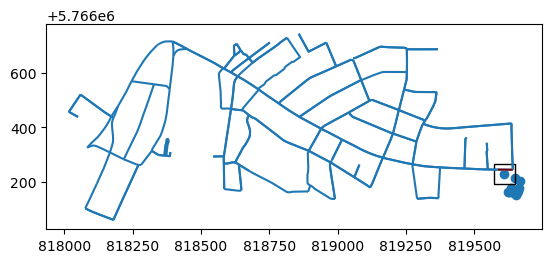

In [7]:
# This is how we  visualize edges and error bound 
#print(edges)
print(type(edges))

# find which edges is selected at time point
# find index of the edge id
loc = np.where(edges_utm["str_id"] == conc(edge_link[count]))
#Save selected edge 
answer_loc = edges_utm.iloc[loc]

# plotting edges and starting point together 
f, ax = plt.subplots()

# location for all point
#locs_utm.plot(ax=ax)
locs_utm.iloc[0:iter, :].plot(ax = ax)

#current location versus edges
#curr_loc.plot(ax=ax)

#err coord 
# better if we just take location at the last and use error bound function 
err_poly.plot(ax=ax, facecolor="none")

# this plot all the road system 
edges_utm.plot(ax=ax)
# this plot the selected edge at time point 
answer_loc.plot(ax=ax, cmap = "Reds")

#print(intersects['index_right'])